In [1]:
import sys
sys.path.append('..')
import statistics
from collections import defaultdict
%reload_ext autoreload

%autoreload 2
import numpy as np
from models.NLP_only_models import lstm
import torch
from collections import defaultdict
import scipy.stats as st
import matplotlib.pyplot as plt


In [2]:
# FILES TO CHANGE (This is where your sequence_nlp_harvey.zip etc is) 

NPY_INPUT_DIR = '../data/extracted_features/combined_ML/harvey/'
NPY_OUTPUT_DIR = '../data/resultsNLP/harvey/'

NUM_TESTS = 25

HIDDEN_DIM0 = 492
NUM_LAYERS0 = 2
BIDIRECTIONAL = False
LEARNING_RATE0 =  0.06594170753730186
MOMENTUM0= 0.4155718228778864
DECAY_FACTOR0 = 0.9994799511941715
EPOCH0 = 1

HIDDEN_DIM1 = 317
NUM_LAYERS1 = 2
ACTIVATION1 = torch.relu
LEARNING_RATE1 =  0.01716338255295094
MOMENTUM1= 0.4076566580373683
DECAY_FACTOR1 = 0.6449016801935564
EPOCH1 = 3

HIDDEN_DIM2 = 445
NUM_LAYERS2 = 2
ACTIVATION2 = torch.tanh
LEARNING_RATE2 =  0.007982950726461421
MOMENTUM2= 0.6406284219061565
DECAY_FACTOR2 =  0.22136475950392637
EPOCH2 = 3

# LSTM -------------------------------------------------------------------*

In [3]:

def plot_cis(binNames, binRatios, priors):
    '''
    Requires a list of group str outputs and bin ratios from get_accuracy_graph - one for each run
    Collect results of both get_accuracy_plot return values -- names and binRatios-- in an array to run this.
    '''
    priors = np.array(priors[0])
    binVals = defaultdict(list)
    for run in range(len(binRatios)):
        for bin in range(len(binRatios[run])):
            binVals[bin+1].append(binRatios[run][bin]) # append the ratio (accuracy) of the bin to list
    cis = []
    means = []
    keys = []
    binLabels = [name for name in binNames[0]]
    for bin in binVals: # Calculate mean and CI for each bin
        keys.append(bin)
        mean = np.mean(binVals[bin])
        means.append(mean)
        standard = statistics.stdev(binVals[bin])
        cis.append(standard)
    plt.figure()  # initiate accuracy plot
    plt.plot(keys, means, label="Mean Accuracy by Bin")  # plot accuracy by bin
    plt.plot(keys, priors, label="Naive Accuracy")
    plt.errorbar(keys, means, yerr=cis)
    plt.xticks(keys, binLabels)
    plt.suptitle('Test classification accuracy rate by user history length (CI .95)')
    plt.xlabel('User history length (lowest to highest), sorted into bins (ascending order)')
    plt.ylabel('Accuracy rate')
    plt.show()
    return


def test_100(X_train, y_train, X_test, y_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    HIDDEN_DIM0 = 364

    for i in range(NUM_TESTS):
        print('starting *********************************', i)
        model = lstm.LSTM(input_dim = 400, hidden_dim = HIDDEN_DIM0, num_layers = NUM_LAYERS0,
                          bidirectional = BIDIRECTIONAL, learning_rate = LEARNING_RATE0,
                          momentum = MOMENTUM0, decay_factor = DECAY_FACTOR0)
        model.learn(X_train, y_train, epochs=EPOCH0)
        
        # evaluate
        
        acc, auc, precision, recall, f1 = model.get_acc_auc_pre_re_f1(X_test, y_test)
        all_results.append([acc, auc, f1, precision, recall])
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        bins, accRates, priors = model.get_accuracy_graph(X_test, y_test, y_train.numpy())
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'lstm_results.npy', results)

    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [4]:
# load data from files

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))

# format npz objects as lists of arrays again
X_tfidf_train = [ torch.Tensor(X_seq_tfidf_train[file]) for file in X_seq_tfidf_train.files]
X_tfidf_test = [ torch.Tensor(X_seq_tfidf_test[file]) for file in X_seq_tfidf_test.files]

X_glove_train = [ torch.Tensor(X_seq_glove_train[file]) for file in X_seq_glove_train.files]
X_glove_test = [ torch.Tensor(X_seq_glove_test[file]) for file in X_seq_glove_test.files]


# build lists with features concatenated

from sklearn.preprocessing import StandardScaler

X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))


starting ********************************* 0
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.2682847896440128
R2 score for bin 1 = -0.08550855085508546
R2 score for bin 2 = 0.3038961038961039
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.17183908045976992
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


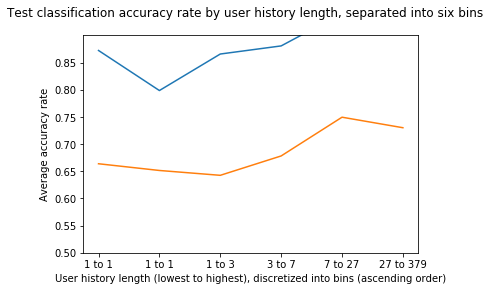

starting ********************************* 1
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.04530453045304528
R2 score for bin 2 = 0.3038961038961039
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.10864745011086507
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


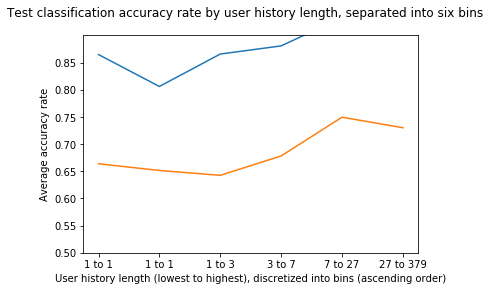

starting ********************************* 2
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.08550855085508546
R2 score for bin 2 = 0.2265512265512265
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.10864745011086507
R2 score for bin 5 = 0.17183908045976992
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


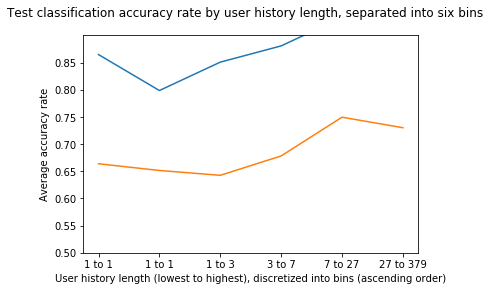

starting ********************************* 3
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.18220064724919083
R2 score for bin 1 = -0.08550855085508546
R2 score for bin 2 = 0.3038961038961039
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


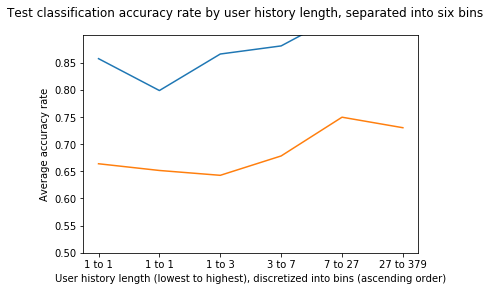

starting ********************************* 4
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.2682847896440128
R2 score for bin 1 = -0.08550855085508546
R2 score for bin 2 = 0.26522366522366525
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


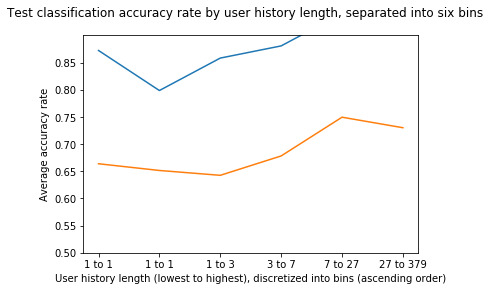

starting ********************************* 5
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.0051005100510048695
R2 score for bin 2 = 0.3425685425685425
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.10864745011086507
R2 score for bin 5 = 0.17183908045976992
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


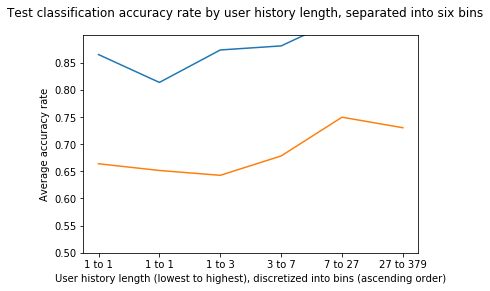

starting ********************************* 6
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.2682847896440128
R2 score for bin 1 = -0.0051005100510048695
R2 score for bin 2 = 0.3038961038961039
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


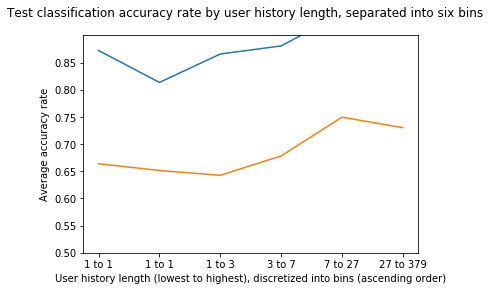

starting ********************************* 7
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.04530453045304528
R2 score for bin 2 = 0.3425685425685425
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.17183908045976992
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


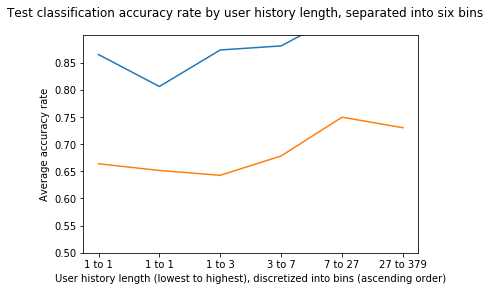

starting ********************************* 8
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.12571257125712565
R2 score for bin 2 = 0.3038961038961039
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.10864745011086507
R2 score for bin 5 = 0.17183908045976992
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


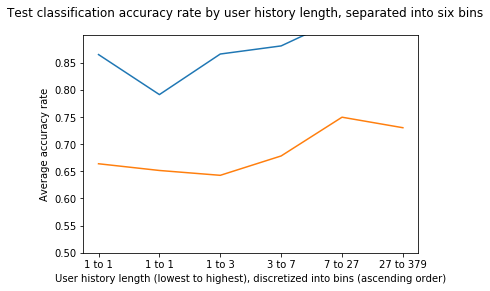

starting ********************************* 9
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.08550855085508546
R2 score for bin 2 = 0.2265512265512265
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.17183908045976992
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


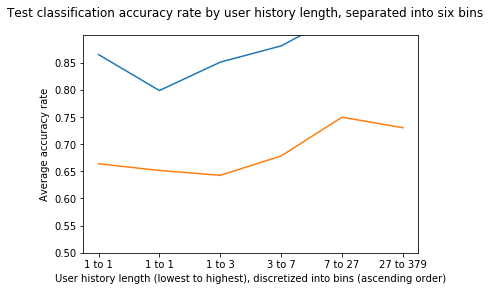

starting ********************************* 10
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.18220064724919083
R2 score for bin 1 = -0.08550855085508546
R2 score for bin 2 = 0.18787878787878787
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.021264367816091756
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


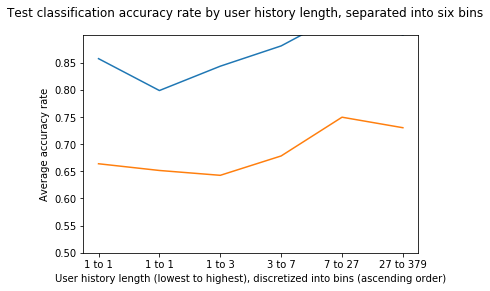

starting ********************************* 11
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.04530453045304528
R2 score for bin 2 = 0.3038961038961039
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


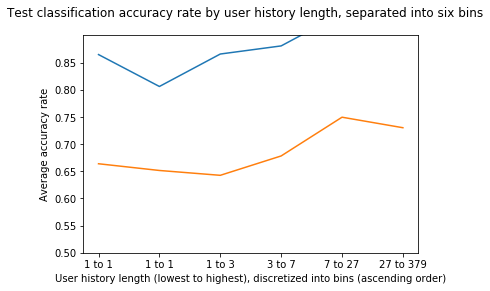

starting ********************************* 12
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.2682847896440128
R2 score for bin 1 = -0.08550855085508546
R2 score for bin 2 = 0.3425685425685425
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


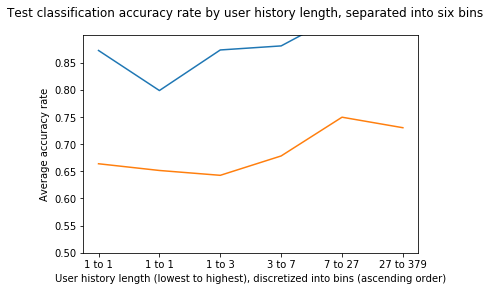

starting ********************************* 13
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.04530453045304528
R2 score for bin 2 = 0.3038961038961039
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.10864745011086507
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


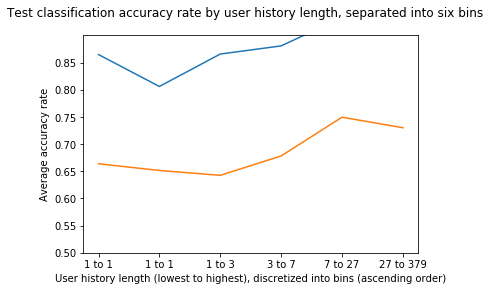

starting ********************************* 14
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.18220064724919083
R2 score for bin 1 = -0.0051005100510048695
R2 score for bin 2 = 0.3425685425685425
R2 score for bin 3 = 0.21149186569747325
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


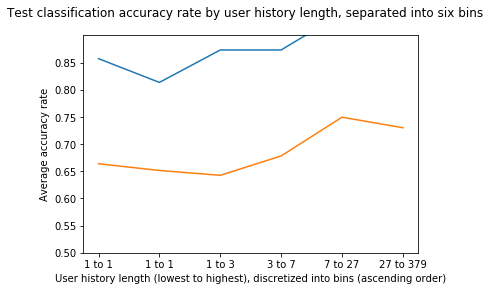

starting ********************************* 15
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.04530453045304528
R2 score for bin 2 = 0.3038961038961039
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


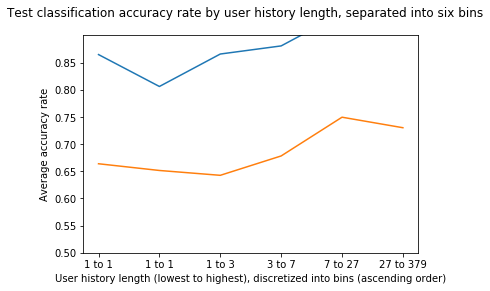

starting ********************************* 16
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.2682847896440128
R2 score for bin 1 = 0.035103510351035205
R2 score for bin 2 = 0.26522366522366525
R2 score for bin 3 = 0.30425752855659405
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


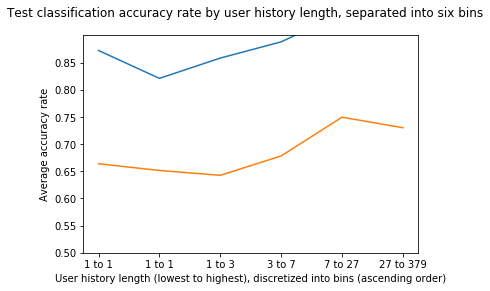

starting ********************************* 17
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.08550855085508546
R2 score for bin 2 = 0.2265512265512265
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.10864745011086507
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


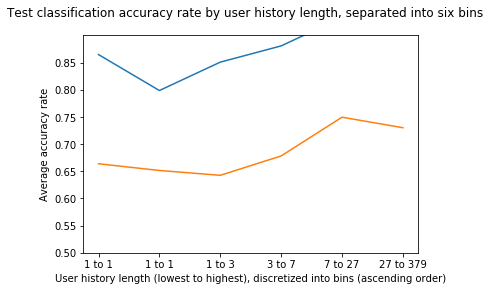

starting ********************************* 18
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.18220064724919083
R2 score for bin 1 = -0.12571257125712565
R2 score for bin 2 = 0.3038961038961039
R2 score for bin 3 = 0.30425752855659405
R2 score for bin 4 = 0.10864745011086507
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


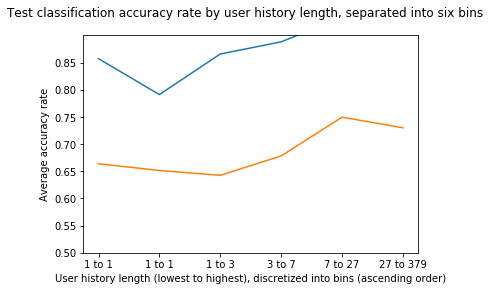

starting ********************************* 19
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.08550855085508546
R2 score for bin 2 = 0.26522366522366525
R2 score for bin 3 = 0.21149186569747325
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


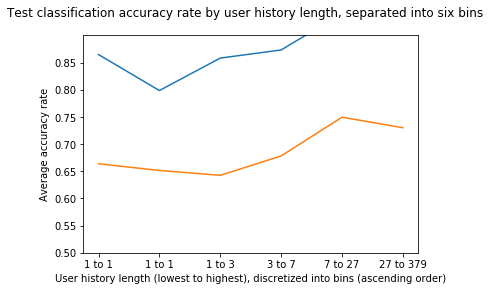

starting ********************************* 20
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.22524271844660182
R2 score for bin 1 = -0.04530453045304528
R2 score for bin 2 = 0.2265512265512265
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.021264367816091756
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


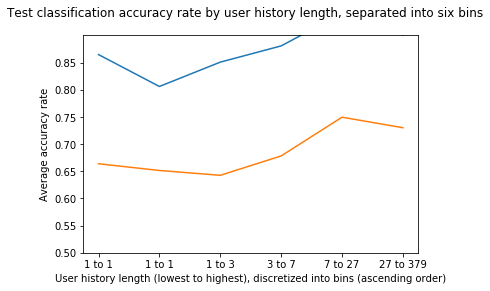

starting ********************************* 21
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.2682847896440128
R2 score for bin 1 = -0.12571257125712565
R2 score for bin 2 = 0.26522366522366525
R2 score for bin 3 = 0.30425752855659405
R2 score for bin 4 = 0.10864745011086507
R2 score for bin 5 = 0.17183908045976992
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


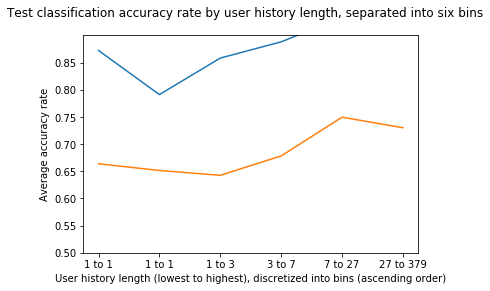

starting ********************************* 22
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.18220064724919083
R2 score for bin 1 = -0.04530453045304528
R2 score for bin 2 = 0.2265512265512265
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.10864745011086507
R2 score for bin 5 = 0.17183908045976992
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


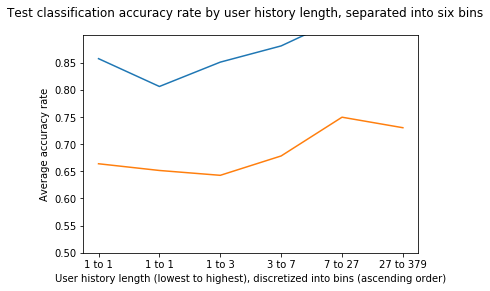

starting ********************************* 23
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.18220064724919083
R2 score for bin 1 = -0.08550855085508546
R2 score for bin 2 = 0.26522366522366525
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.10864745011086507
R2 score for bin 5 = 0.0965517241379309
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


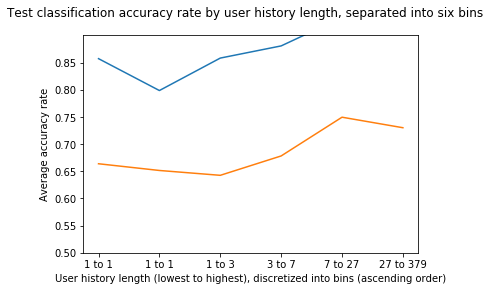

starting ********************************* 24
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.2682847896440128
R2 score for bin 1 = -0.04530453045304528
R2 score for bin 2 = 0.2265512265512265
R2 score for bin 3 = 0.2578746971270336
R2 score for bin 4 = 0.20768662232076895
R2 score for bin 5 = 0.17183908045976992
True proportion of + scores in bin 0 = 0.7744360902255639
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.7985074626865671
True proportion of + scores in bin 4 = 0.917910447761194
True proportion of + scores in bin 5 = 0.8854961832061069


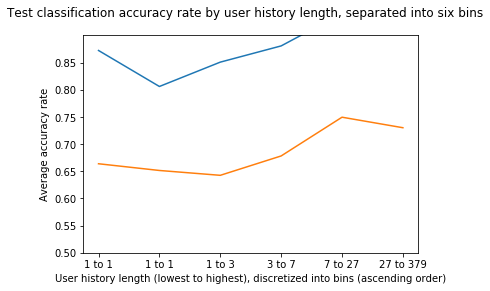

In [5]:

acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test)

Acc: 0.8761
AUC: 0.8629100296941804
F1: 0.9272381161778158
Precision: 0.8854843522861943
Recall: 0.9731278890600925


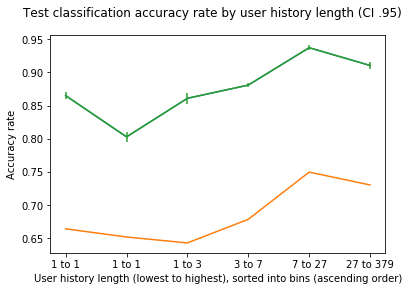

In [6]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# BASELINE -------------------------------------------------------------------*

In [7]:
from collections import defaultdict
from models import baseline_mlp
import numpy as np
import torch
from sklearn.metrics import roc_auc_score
import statistics
import matplotlib.pyplot as plt

GLOVE_DIR = NPY_INPUT_DIR
TFIDF_DIR = NPY_INPUT_DIR

# with histories

In [8]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM1, num_layers= NUM_LAYERS1,
                                    activation_function = ACTIVATION1, learning_rate =  LEARNING_RATE1,
                                    momentum = MOMENTUM1, decay_factor = DECAY_FACTOR1)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH1)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))

        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'history_baseline_results.npy', results)
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [9]:
# retieve test data history sequence lengths from LSTM data
X_hist_len_test = np.load(NPY_INPUT_DIR + 'full_hist_lens_test.npy')

# load features
X_labeled_train_glove = np.load(GLOVE_DIR + 'X_labeled_train.npy')
X_histories_train_glove = np.load(GLOVE_DIR + 'X_histories_train.npy')
X_labeled_test_glove = np.load(GLOVE_DIR + 'X_labeled_test.npy')
X_histories_test_glove = np.load(GLOVE_DIR + 'X_histories_test.npy')
 
y_train = np.load(NPY_INPUT_DIR + 'y_train.npy')
y_test = np.load(NPY_INPUT_DIR + 'y_test.npy')

X_labeled_train_tfidf = np.load(TFIDF_DIR + 'trainTweets.npy')
X_histories_train_tfidf = np.load(TFIDF_DIR + 'trainHistories.npy')
X_labeled_test_tfidf = np.load(TFIDF_DIR + 'testTweets.npy')
X_histories_test_tfidf = np.load(TFIDF_DIR + 'testHistories.npy')

y_train_tfidf = np.load(TFIDF_DIR + 'trainClassifications.npy')
y_test_tfidf = np.load(TFIDF_DIR + 'testClassifications.npy')


# Normalized

from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()


# TODO FIX NAMES!           
X_labeled_train_glove_norm    = scaler1.fit_transform(X_labeled_train_glove)
X_histories_train_glove_norm  = scaler2.fit_transform(X_histories_train_glove)
X_labeled_test_glove_norm     = scaler1.transform(X_labeled_test_glove)
X_histories_test_glove_norm  = scaler2.transform(X_histories_test_glove)

X_labeled_train_tfidf_norm    = scaler3.fit_transform(X_labeled_train_tfidf)
X_histories_train_tfidf_norm  = scaler4.fit_transform(X_histories_train_tfidf)
X_labeled_test_tfidf_norm     = scaler3.transform(X_labeled_test_tfidf)
X_histories_test_tfidf_norm   = scaler4.transform(X_histories_test_tfidf)

# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                          X_histories_train_glove_norm, X_histories_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                         X_histories_test_glove_norm, X_histories_test_tfidf_norm),
                        axis = 1)


epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.495
[1,   400] loss: 0.462
[1,   600] loss: 0.435
[1,   800] loss: 0.374
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.309
[2,   400] loss: 0.314
[2,   600] loss: 0.319
[2,   800] loss: 0.291
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.250
[3,   400] loss: 0.246
[3,   600] loss: 0.234
[3,   800] loss: 0.257
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083969465

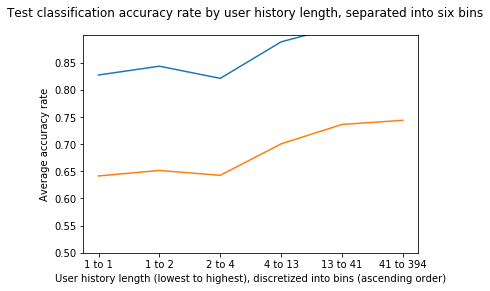

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.477
[1,   400] loss: 0.422
[1,   600] loss: 0.459
[1,   800] loss: 0.393
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.326
[2,   400] loss: 0.322
[2,   600] loss: 0.308
[2,   800] loss: 0.296
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.236
[3,   400] loss: 0.251
[3,   600] loss: 0.263
[3,   800] loss: 0.244
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083969465

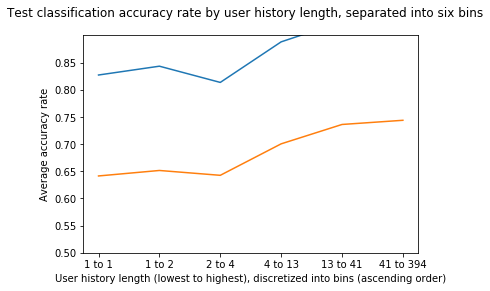

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.529
[1,   400] loss: 0.450
[1,   600] loss: 0.422
[1,   800] loss: 0.414
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.346
[2,   400] loss: 0.339
[2,   600] loss: 0.316
[2,   800] loss: 0.319
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.256
[3,   400] loss: 0.282
[3,   600] loss: 0.253
[3,   800] loss: 0.264
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908396946

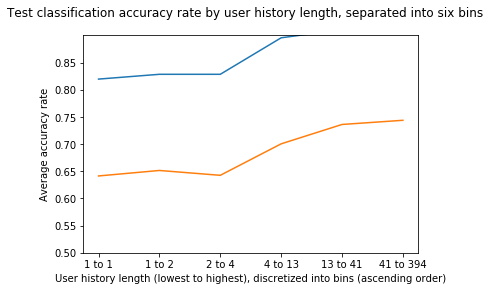

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.533
[1,   400] loss: 0.423
[1,   600] loss: 0.397
[1,   800] loss: 0.382
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.321
[2,   400] loss: 0.323
[2,   600] loss: 0.282
[2,   800] loss: 0.287
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.243
[3,   400] loss: 0.239
[3,   600] loss: 0.242
[3,   800] loss: 0.238
R2 score for bin 0 = 0.030612244897958996
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839694

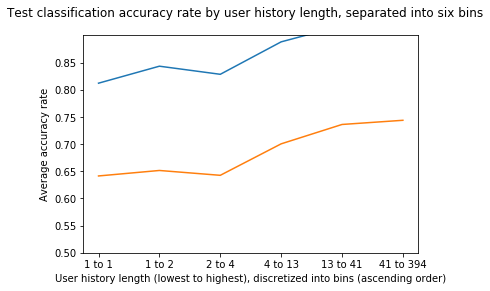

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.523
[1,   400] loss: 0.450
[1,   600] loss: 0.434
[1,   800] loss: 0.369
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.337
[2,   400] loss: 0.305
[2,   600] loss: 0.306
[2,   800] loss: 0.312
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.259
[3,   400] loss: 0.261
[3,   600] loss: 0.251
[3,   800] loss: 0.237
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.2265512265512265
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083969465

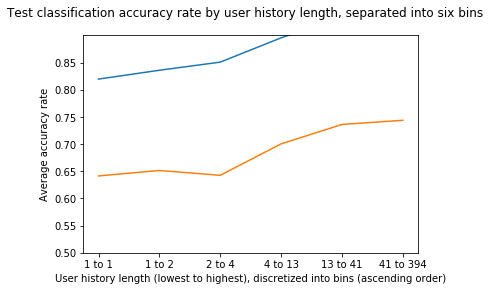

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.535
[1,   400] loss: 0.448
[1,   600] loss: 0.433
[1,   800] loss: 0.376
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.320
[2,   400] loss: 0.333
[2,   600] loss: 0.306
[2,   800] loss: 0.318
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.250
[3,   400] loss: 0.278
[3,   600] loss: 0.247
[3,   800] loss: 0.251
R2 score for bin 0 = 0.030612244897958996
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908396946

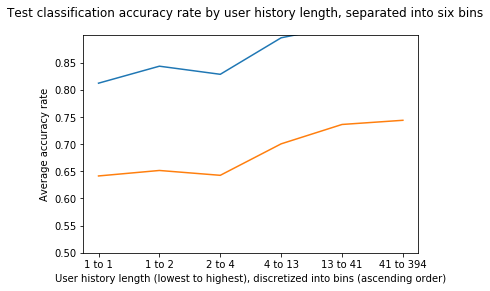

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.521
[1,   400] loss: 0.451
[1,   600] loss: 0.424
[1,   800] loss: 0.385
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.311
[2,   400] loss: 0.336
[2,   600] loss: 0.305
[2,   800] loss: 0.300
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.247
[3,   400] loss: 0.251
[3,   600] loss: 0.248
[3,   800] loss: 0.255
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.08263305322128855
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839694

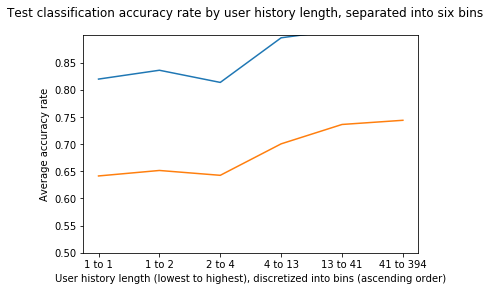

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.520
[1,   400] loss: 0.453
[1,   600] loss: 0.426
[1,   800] loss: 0.387
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.339
[2,   400] loss: 0.310
[2,   600] loss: 0.336
[2,   800] loss: 0.294
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.257
[3,   400] loss: 0.268
[3,   600] loss: 0.255
[3,   800] loss: 0.242
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.2265512265512265
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083969465

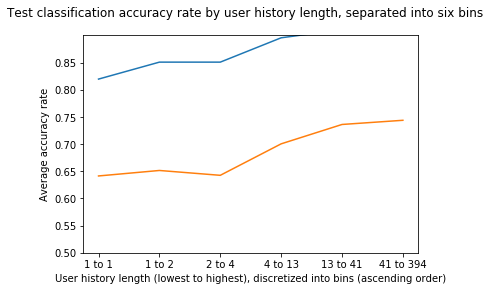

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.507
[1,   400] loss: 0.475
[1,   600] loss: 0.423
[1,   800] loss: 0.368
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.346
[2,   400] loss: 0.330
[2,   600] loss: 0.324
[2,   800] loss: 0.293
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.260
[3,   400] loss: 0.268
[3,   600] loss: 0.253
[3,   800] loss: 0.258
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908396946

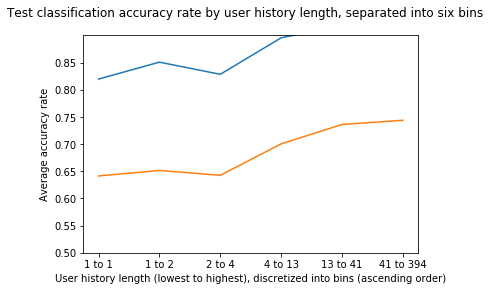

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.520
[1,   400] loss: 0.460
[1,   600] loss: 0.417
[1,   800] loss: 0.391
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.359
[2,   400] loss: 0.324
[2,   600] loss: 0.316
[2,   800] loss: 0.297
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.266
[3,   400] loss: 0.250
[3,   600] loss: 0.264
[3,   800] loss: 0.260
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = -0.036904761904761996
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083969

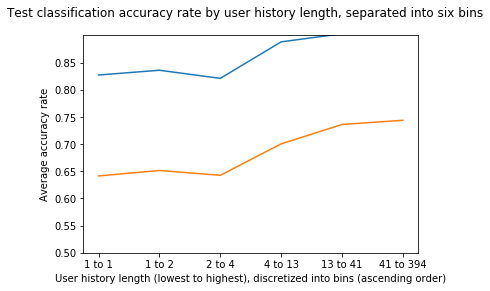

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.503
[1,   400] loss: 0.451
[1,   600] loss: 0.395
[1,   800] loss: 0.411
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.318
[2,   400] loss: 0.323
[2,   600] loss: 0.301
[2,   800] loss: 0.293
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.233
[3,   400] loss: 0.222
[3,   600] loss: 0.247
[3,   800] loss: 0.278
R2 score for bin 0 = 0.14693877551020385
R2 score for bin 1 = 0.27632763276327643
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.29301948051948046
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908396946

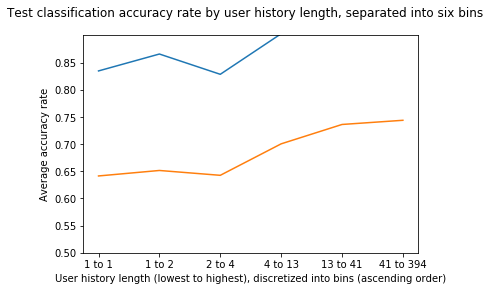

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.499
[1,   400] loss: 0.462
[1,   600] loss: 0.434
[1,   800] loss: 0.395
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.326
[2,   400] loss: 0.312
[2,   600] loss: 0.315
[2,   800] loss: 0.298
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.247
[3,   400] loss: 0.259
[3,   600] loss: 0.239
[3,   800] loss: 0.260
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839694

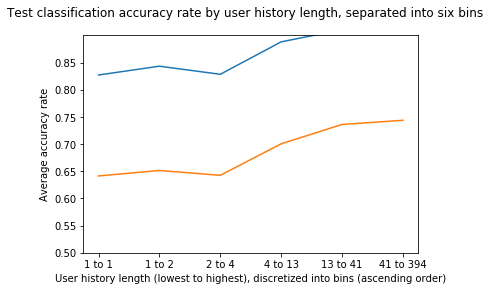

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.490
[1,   400] loss: 0.461
[1,   600] loss: 0.412
[1,   800] loss: 0.374
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.328
[2,   400] loss: 0.281
[2,   600] loss: 0.286
[2,   800] loss: 0.303
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.242
[3,   400] loss: 0.237
[3,   600] loss: 0.249
[3,   800] loss: 0.225
R2 score for bin 0 = 0.14693877551020385
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.3474025974025974
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839694656

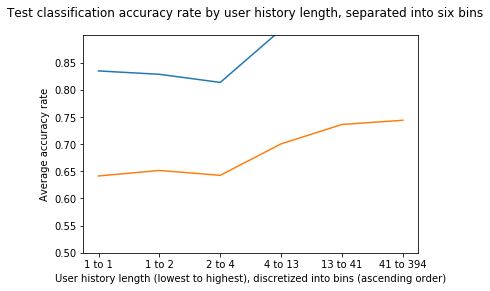

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.552
[1,   400] loss: 0.422
[1,   600] loss: 0.410
[1,   800] loss: 0.384
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.311
[2,   400] loss: 0.331
[2,   600] loss: 0.304
[2,   800] loss: 0.281
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.239
[3,   400] loss: 0.264
[3,   600] loss: 0.245
[3,   800] loss: 0.232
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908396946

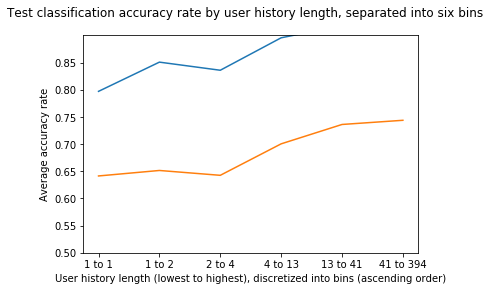

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.526
[1,   400] loss: 0.477
[1,   600] loss: 0.433
[1,   800] loss: 0.365
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.345
[2,   400] loss: 0.293
[2,   600] loss: 0.333
[2,   800] loss: 0.309
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.247
[3,   400] loss: 0.265
[3,   600] loss: 0.238
[3,   800] loss: 0.258
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839694

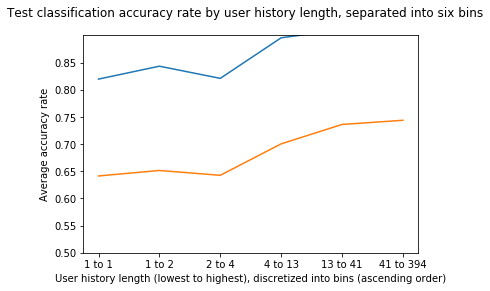

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.526
[1,   400] loss: 0.448
[1,   600] loss: 0.392
[1,   800] loss: 0.392
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.349
[2,   400] loss: 0.301
[2,   600] loss: 0.309
[2,   800] loss: 0.281
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.238
[3,   400] loss: 0.256
[3,   600] loss: 0.251
[3,   800] loss: 0.247
R2 score for bin 0 = 0.14693877551020385
R2 score for bin 1 = 0.035103510351035205
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839694

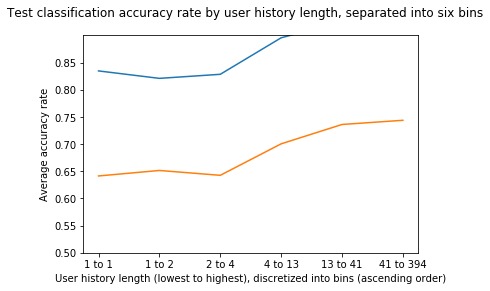

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.499
[1,   400] loss: 0.474
[1,   600] loss: 0.418
[1,   800] loss: 0.359
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.286
[2,   400] loss: 0.281
[2,   600] loss: 0.333
[2,   800] loss: 0.305
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.234
[3,   400] loss: 0.250
[3,   600] loss: 0.254
[3,   800] loss: 0.220
R2 score for bin 0 = 0.030612244897958996
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.3474025974025974
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083969465

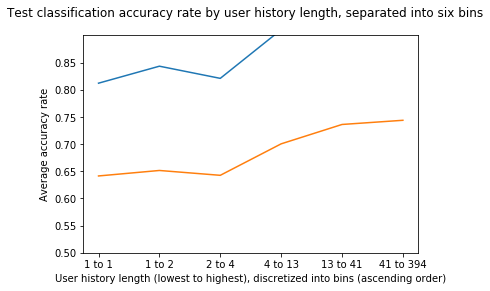

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.544
[1,   400] loss: 0.428
[1,   600] loss: 0.399
[1,   800] loss: 0.378
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.344
[2,   400] loss: 0.287
[2,   600] loss: 0.309
[2,   800] loss: 0.296
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.245
[3,   400] loss: 0.231
[3,   600] loss: 0.255
[3,   800] loss: 0.249
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083969465

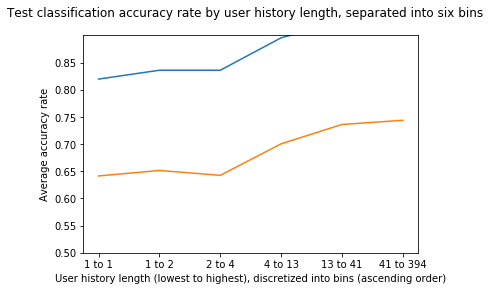

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.528
[1,   400] loss: 0.471
[1,   600] loss: 0.422
[1,   800] loss: 0.403
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.333
[2,   400] loss: 0.331
[2,   600] loss: 0.334
[2,   800] loss: 0.309
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.260
[3,   400] loss: 0.273
[3,   600] loss: 0.251
[3,   800] loss: 0.255
R2 score for bin 0 = 0.14693877551020385
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083969465

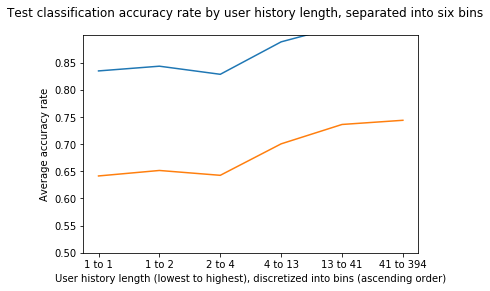

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.538
[1,   400] loss: 0.426
[1,   600] loss: 0.447
[1,   800] loss: 0.432
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.351
[2,   400] loss: 0.356
[2,   600] loss: 0.339
[2,   800] loss: 0.307
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.287
[3,   400] loss: 0.277
[3,   600] loss: 0.273
[3,   800] loss: 0.256
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908396946

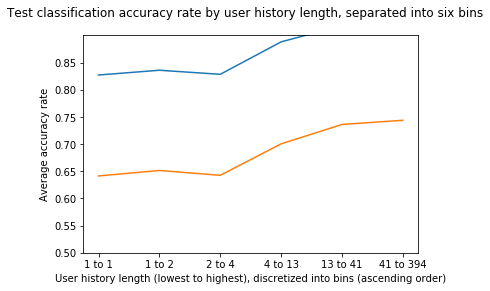

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.499
[1,   400] loss: 0.439
[1,   600] loss: 0.406
[1,   800] loss: 0.417
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.332
[2,   400] loss: 0.336
[2,   600] loss: 0.286
[2,   800] loss: 0.295
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.246
[3,   400] loss: 0.255
[3,   600] loss: 0.245
[3,   800] loss: 0.245
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.18787878787878787
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = -0.036904761904761996
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083969

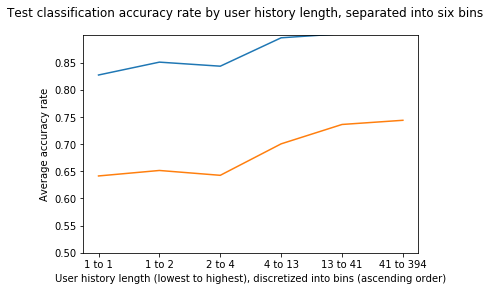

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.544
[1,   400] loss: 0.465
[1,   600] loss: 0.396
[1,   800] loss: 0.384
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.362
[2,   400] loss: 0.313
[2,   600] loss: 0.309
[2,   800] loss: 0.295
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.249
[3,   400] loss: 0.252
[3,   600] loss: 0.262
[3,   800] loss: 0.260
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839694

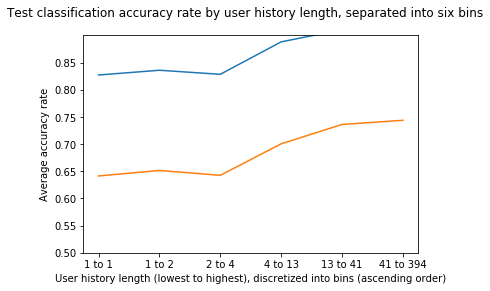

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.527
[1,   400] loss: 0.450
[1,   600] loss: 0.437
[1,   800] loss: 0.397
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.350
[2,   400] loss: 0.335
[2,   600] loss: 0.312
[2,   800] loss: 0.327
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.273
[3,   400] loss: 0.261
[3,   600] loss: 0.277
[3,   800] loss: 0.249
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.18787878787878787
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908396946

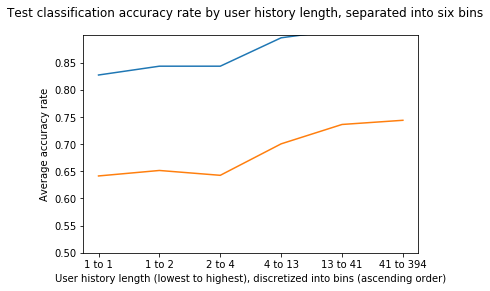

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.546
[1,   400] loss: 0.459
[1,   600] loss: 0.398
[1,   800] loss: 0.390
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.349
[2,   400] loss: 0.289
[2,   600] loss: 0.350
[2,   800] loss: 0.291
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.284
[3,   400] loss: 0.256
[3,   600] loss: 0.239
[3,   800] loss: 0.247
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839694

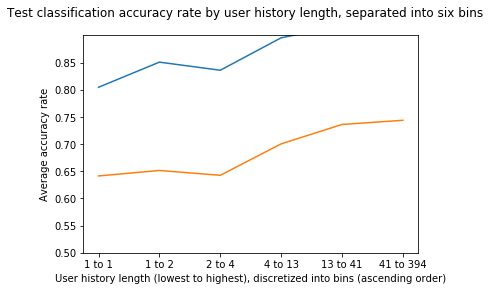

epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.521
[1,   400] loss: 0.420
[1,   600] loss: 0.416
[1,   800] loss: 0.422
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.343
[2,   400] loss: 0.318
[2,   600] loss: 0.292
[2,   800] loss: 0.304
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.251
[3,   400] loss: 0.238
[3,   600] loss: 0.248
[3,   800] loss: 0.267
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083969465

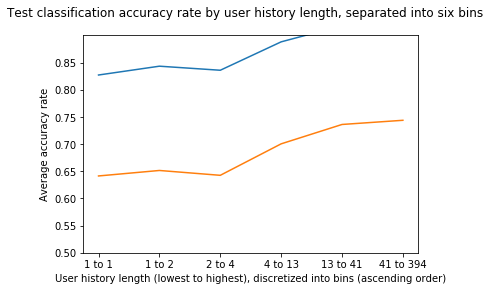

In [10]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list= test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

Acc: 0.8730499999999998
AUC: 0.8704521474708925
F1: 0.9244853937610265
Precision: 0.8933395047487841
Recall: 0.9579044684129431


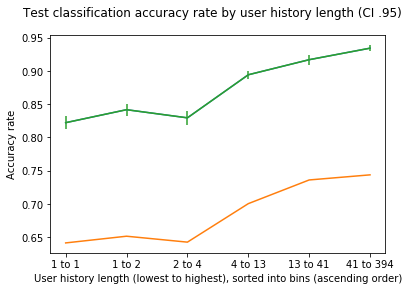

In [11]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# without histories

In [12]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM2, num_layers= NUM_LAYERS2,
                                    activation_function = ACTIVATION2, learning_rate =  LEARNING_RATE2,
                                    momentum = MOMENTUM2, decay_factor = DECAY_FACTOR2)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH2)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))
        all_results.append([acc, auc, f1, precision, recall])
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    #baseline.plot_cis(bin_names, graph_results)

    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'nohistory_baseline_results.npy', results)
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [13]:
# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm),
                        axis = 1)

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.497
[1,   400] loss: 0.349
[1,   600] loss: 0.342
[1,   800] loss: 0.345
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.275
[2,   400] loss: 0.301
[2,   600] loss: 0.306
[2,   800] loss: 0.270
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.281
[3,   400] loss: 0.285
[3,   600] loss: 0.292
[3,   800] loss: 0.246
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839

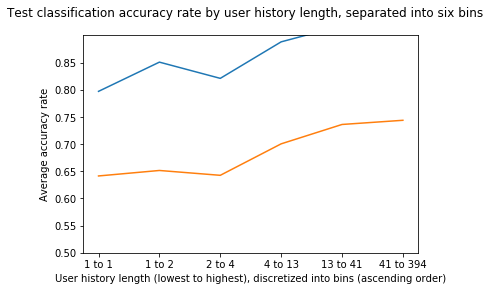

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.503
[1,   400] loss: 0.377
[1,   600] loss: 0.318
[1,   800] loss: 0.314
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.242
[2,   400] loss: 0.293
[2,   600] loss: 0.307
[2,   800] loss: 0.298
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.267
[3,   400] loss: 0.242
[3,   600] loss: 0.296
[3,   800] loss: 0.288
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839

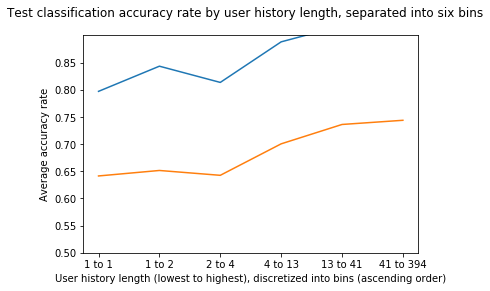

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.520
[1,   400] loss: 0.368
[1,   600] loss: 0.339
[1,   800] loss: 0.300
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.279
[2,   400] loss: 0.293
[2,   600] loss: 0.283
[2,   800] loss: 0.286
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.281
[3,   400] loss: 0.254
[3,   600] loss: 0.300
[3,   800] loss: 0.261
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = -0.0051005100510048695
R2 score for bin 2 = -0.0054834054834054236
R2 score for bin 3 = 0.07548701298701299
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 =

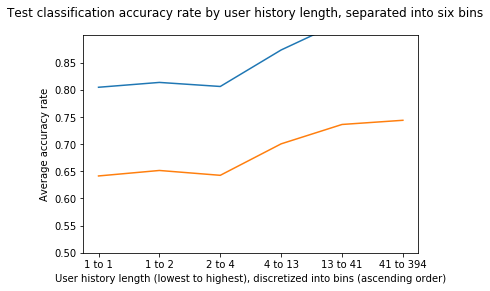

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.522
[1,   400] loss: 0.376
[1,   600] loss: 0.334
[1,   800] loss: 0.306
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.288
[2,   400] loss: 0.255
[2,   600] loss: 0.300
[2,   800] loss: 0.307
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.291
[3,   400] loss: 0.277
[3,   600] loss: 0.248
[3,   800] loss: 0.288
R2 score for bin 0 = -0.12448979591836751
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083

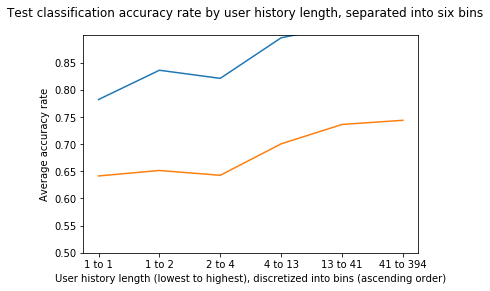

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.531
[1,   400] loss: 0.367
[1,   600] loss: 0.308
[1,   800] loss: 0.345
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.306
[2,   400] loss: 0.291
[2,   600] loss: 0.270
[2,   800] loss: 0.304
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.314
[3,   400] loss: 0.258
[3,   600] loss: 0.270
[3,   800] loss: 0.282
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908

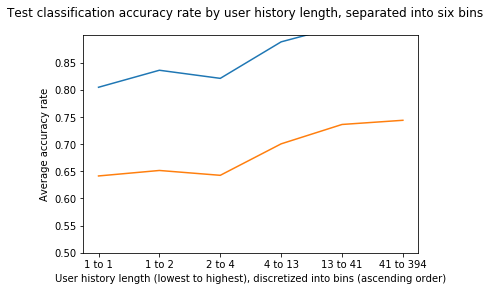

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.533
[1,   400] loss: 0.354
[1,   600] loss: 0.344
[1,   800] loss: 0.309
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.302
[2,   400] loss: 0.292
[2,   600] loss: 0.291
[2,   800] loss: 0.277
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.264
[3,   400] loss: 0.292
[3,   600] loss: 0.277
[3,   800] loss: 0.284
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = -0.0054834054834054236
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908

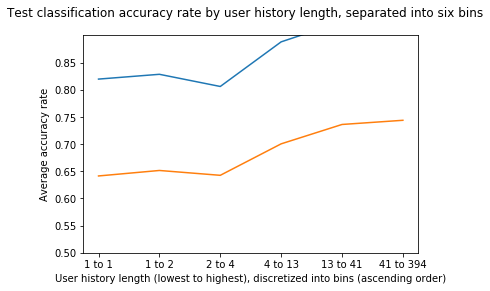

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.531
[1,   400] loss: 0.390
[1,   600] loss: 0.313
[1,   800] loss: 0.321
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.322
[2,   400] loss: 0.301
[2,   600] loss: 0.291
[2,   800] loss: 0.244
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.265
[3,   400] loss: 0.270
[3,   600] loss: 0.273
[3,   800] loss: 0.302
R2 score for bin 0 = 0.030612244897958996
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839

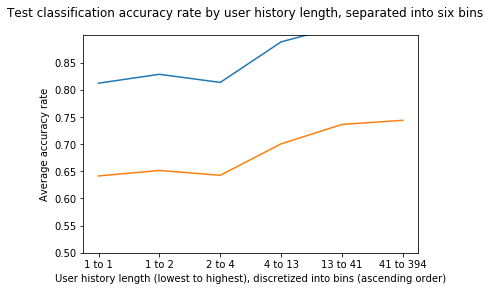

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.513
[1,   400] loss: 0.380
[1,   600] loss: 0.337
[1,   800] loss: 0.313
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.295
[2,   400] loss: 0.281
[2,   600] loss: 0.302
[2,   800] loss: 0.275
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.283
[3,   400] loss: 0.279
[3,   600] loss: 0.272
[3,   800] loss: 0.272
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = -0.04415584415584428
R2 score for bin 3 = 0.29301948051948046
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908

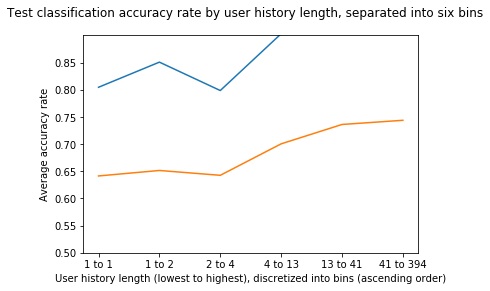

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.514
[1,   400] loss: 0.371
[1,   600] loss: 0.341
[1,   800] loss: 0.333
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.272
[2,   400] loss: 0.282
[2,   600] loss: 0.311
[2,   800] loss: 0.293
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.270
[3,   400] loss: 0.263
[3,   600] loss: 0.300
[3,   800] loss: 0.279
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908

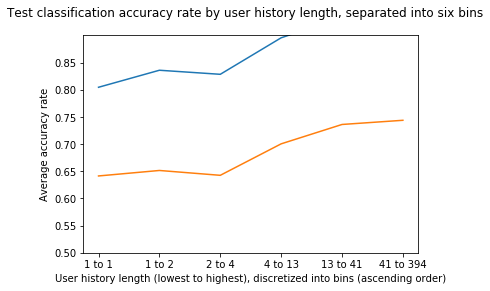

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.509
[1,   400] loss: 0.381
[1,   600] loss: 0.363
[1,   800] loss: 0.307
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.285
[2,   400] loss: 0.298
[2,   600] loss: 0.267
[2,   800] loss: 0.316
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.274
[3,   400] loss: 0.270
[3,   600] loss: 0.298
[3,   800] loss: 0.275
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.18787878787878787
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083

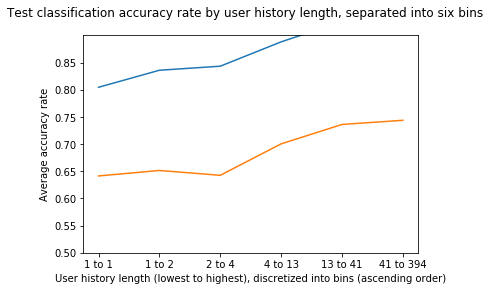

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.494
[1,   400] loss: 0.355
[1,   600] loss: 0.346
[1,   800] loss: 0.343
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.280
[2,   400] loss: 0.290
[2,   600] loss: 0.293
[2,   800] loss: 0.290
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.279
[3,   400] loss: 0.271
[3,   600] loss: 0.272
[3,   800] loss: 0.286
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = -0.0054834054834054236
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9

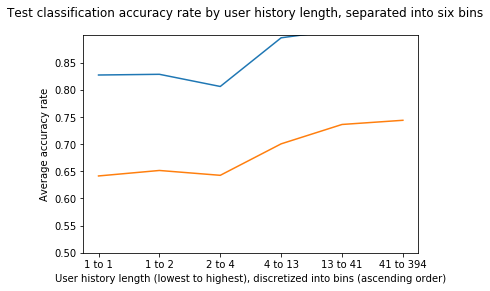

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.500
[1,   400] loss: 0.372
[1,   600] loss: 0.355
[1,   800] loss: 0.326
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.282
[2,   400] loss: 0.284
[2,   600] loss: 0.305
[2,   800] loss: 0.278
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.275
[3,   400] loss: 0.268
[3,   600] loss: 0.296
[3,   800] loss: 0.265
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839

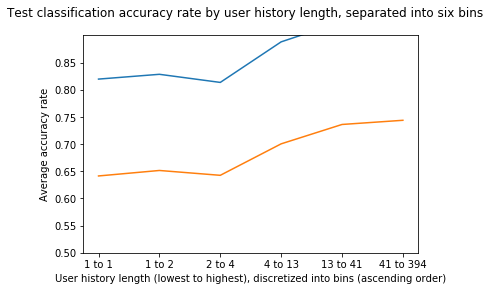

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.534
[1,   400] loss: 0.363
[1,   600] loss: 0.335
[1,   800] loss: 0.342
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.302
[2,   400] loss: 0.276
[2,   600] loss: 0.292
[2,   800] loss: 0.300
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.283
[3,   400] loss: 0.277
[3,   600] loss: 0.291
[3,   800] loss: 0.273
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908396

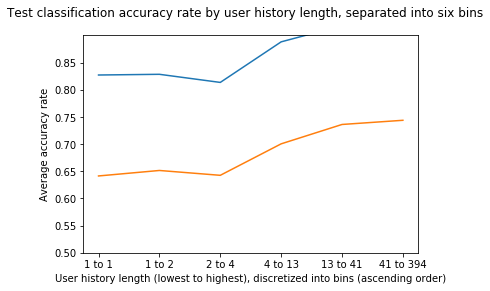

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.506
[1,   400] loss: 0.371
[1,   600] loss: 0.309
[1,   800] loss: 0.344
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.297
[2,   400] loss: 0.276
[2,   600] loss: 0.276
[2,   800] loss: 0.300
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.248
[3,   400] loss: 0.280
[3,   600] loss: 0.285
[3,   800] loss: 0.289
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = -0.0054834054834054236
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90

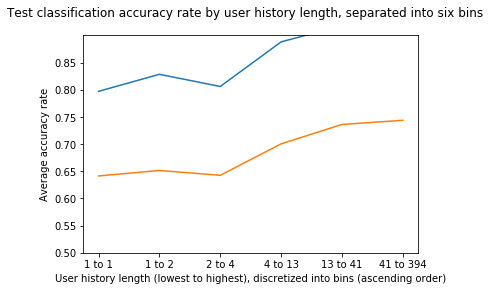

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.527
[1,   400] loss: 0.350
[1,   600] loss: 0.324
[1,   800] loss: 0.335
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.287
[2,   400] loss: 0.290
[2,   600] loss: 0.296
[2,   800] loss: 0.277
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.293
[3,   400] loss: 0.284
[3,   600] loss: 0.269
[3,   800] loss: 0.258
R2 score for bin 0 = -0.08571428571428608
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839

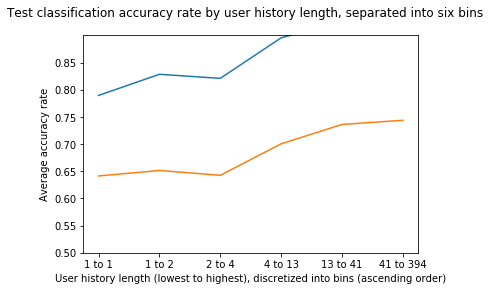

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.526
[1,   400] loss: 0.395
[1,   600] loss: 0.324
[1,   800] loss: 0.304
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.282
[2,   400] loss: 0.283
[2,   600] loss: 0.284
[2,   800] loss: 0.313
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.308
[3,   400] loss: 0.285
[3,   600] loss: 0.257
[3,   800] loss: 0.265
R2 score for bin 0 = 0.030612244897958996
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = -0.0054834054834054236
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9

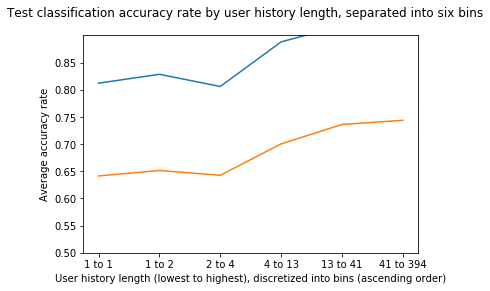

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.502
[1,   400] loss: 0.392
[1,   600] loss: 0.355
[1,   800] loss: 0.313
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.281
[2,   400] loss: 0.308
[2,   600] loss: 0.280
[2,   800] loss: 0.289
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.278
[3,   400] loss: 0.252
[3,   600] loss: 0.283
[3,   800] loss: 0.299
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = -0.04415584415584428
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90

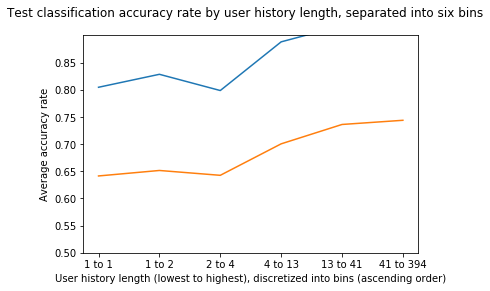

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.505
[1,   400] loss: 0.360
[1,   600] loss: 0.338
[1,   800] loss: 0.345
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.290
[2,   400] loss: 0.302
[2,   600] loss: 0.278
[2,   800] loss: 0.292
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.250
[3,   400] loss: 0.277
[3,   600] loss: 0.290
[3,   800] loss: 0.297
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908

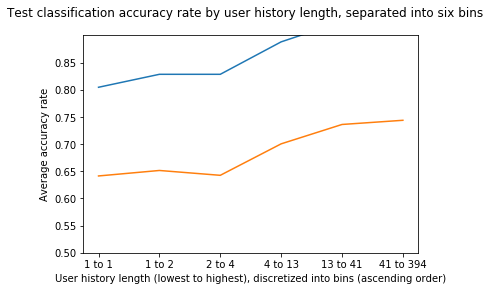

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.533
[1,   400] loss: 0.390
[1,   600] loss: 0.323
[1,   800] loss: 0.319
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.280
[2,   400] loss: 0.302
[2,   600] loss: 0.273
[2,   800] loss: 0.300
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.267
[3,   400] loss: 0.299
[3,   600] loss: 0.260
[3,   800] loss: 0.284
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839

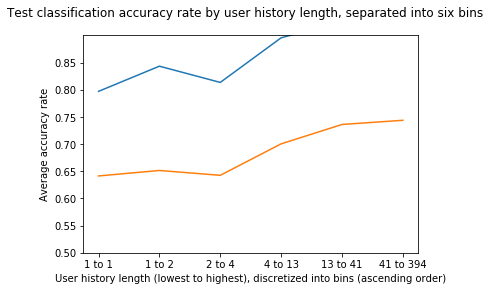

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.499
[1,   400] loss: 0.393
[1,   600] loss: 0.333
[1,   800] loss: 0.330
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.253
[2,   400] loss: 0.321
[2,   600] loss: 0.295
[2,   800] loss: 0.286
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.279
[3,   400] loss: 0.284
[3,   600] loss: 0.288
[3,   800] loss: 0.256
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.3578431372549019
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839

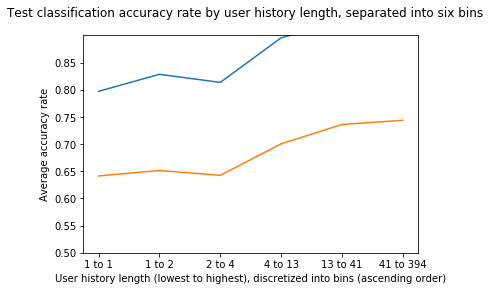

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.534
[1,   400] loss: 0.358
[1,   600] loss: 0.330
[1,   800] loss: 0.327
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.296
[2,   400] loss: 0.289
[2,   600] loss: 0.301
[2,   800] loss: 0.269
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.280
[3,   400] loss: 0.254
[3,   600] loss: 0.278
[3,   800] loss: 0.291
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.44957983193277307
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839

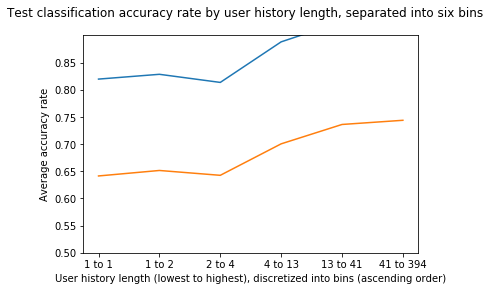

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.542
[1,   400] loss: 0.351
[1,   600] loss: 0.323
[1,   800] loss: 0.347
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.274
[2,   400] loss: 0.286
[2,   600] loss: 0.283
[2,   800] loss: 0.319
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.302
[3,   400] loss: 0.272
[3,   600] loss: 0.274
[3,   800] loss: 0.269
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.035103510351035205
R2 score for bin 2 = -0.0054834054834054236
R2 score for bin 3 = 0.29301948051948046
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.08263305322128855
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0

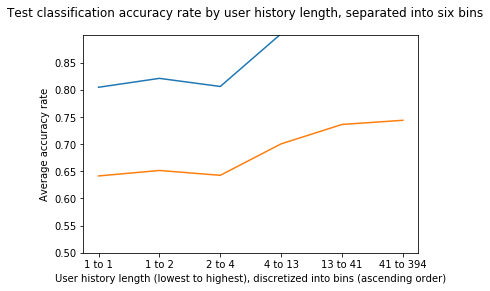

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.527
[1,   400] loss: 0.341
[1,   600] loss: 0.355
[1,   800] loss: 0.329
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.323
[2,   400] loss: 0.279
[2,   600] loss: 0.278
[2,   800] loss: 0.278
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.287
[3,   400] loss: 0.262
[3,   600] loss: 0.270
[3,   800] loss: 0.290
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.29301948051948046
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.9083

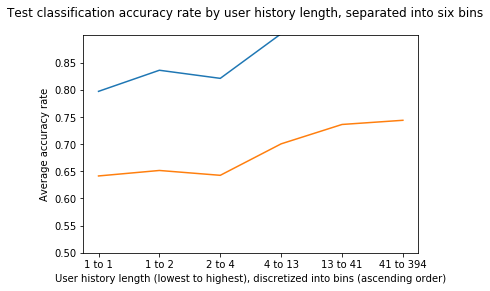

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.520
[1,   400] loss: 0.375
[1,   600] loss: 0.349
[1,   800] loss: 0.286
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.292
[2,   400] loss: 0.301
[2,   600] loss: 0.272
[2,   800] loss: 0.289
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.286
[3,   400] loss: 0.291
[3,   600] loss: 0.263
[3,   800] loss: 0.268
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.908396

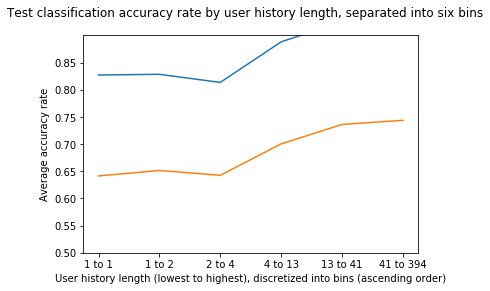

epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.518
[1,   400] loss: 0.366
[1,   600] loss: 0.308
[1,   800] loss: 0.331
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.303
[2,   400] loss: 0.282
[2,   600] loss: 0.295
[2,   800] loss: 0.277
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.255
[3,   400] loss: 0.303
[3,   600] loss: 0.299
[3,   800] loss: 0.254
R2 score for bin 0 = -0.08571428571428608
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scores in bin 2 = 0.7388059701492538
True proportion of + scores in bin 3 = 0.835820895522388
True proportion of + scores in bin 4 = 0.8955223880597015
True proportion of + scores in bin 5 = 0.90839

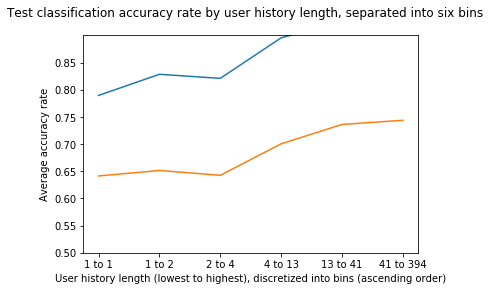

In [14]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

Acc: 0.8666499999999999
AUC: 0.8718235900366329
F1: 0.9208249167304159
Precision: 0.8882663246843859
Recall: 0.9558705701078581


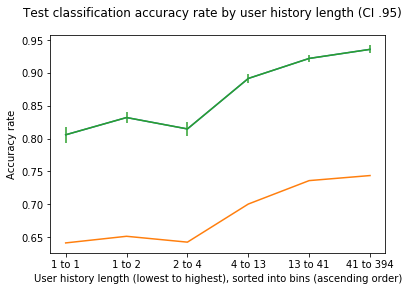

In [15]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)



